files/soil.tif loaded successfully.
files/rainfall.tif loaded successfully.
files/landcover.tif loaded successfully.
files/slope.tif loaded successfully.
files/research_area.shp loaded successfully.
files/research_area.dbf loaded successfully.
files/research_area.shx loaded successfully.
CRS used for project: epsg:2157.
Old files/soil_clip.tif has been replaced.
Old files/rainfall_clip.tif has been replaced.
Old files/landcover_clip.tif has been replaced.
Old files/slope_clip.tif has been replaced.
Data types: soil: <class 'numpy.ndarray'> , rainfall: <class 'numpy.ndarray'> , landcover: <class 'numpy.ndarray'>, slope: <class 'numpy.ndarray'>
Old Soil_Erosion_Risk.tif has been replaced.


<IPython.core.display.Javascript object>


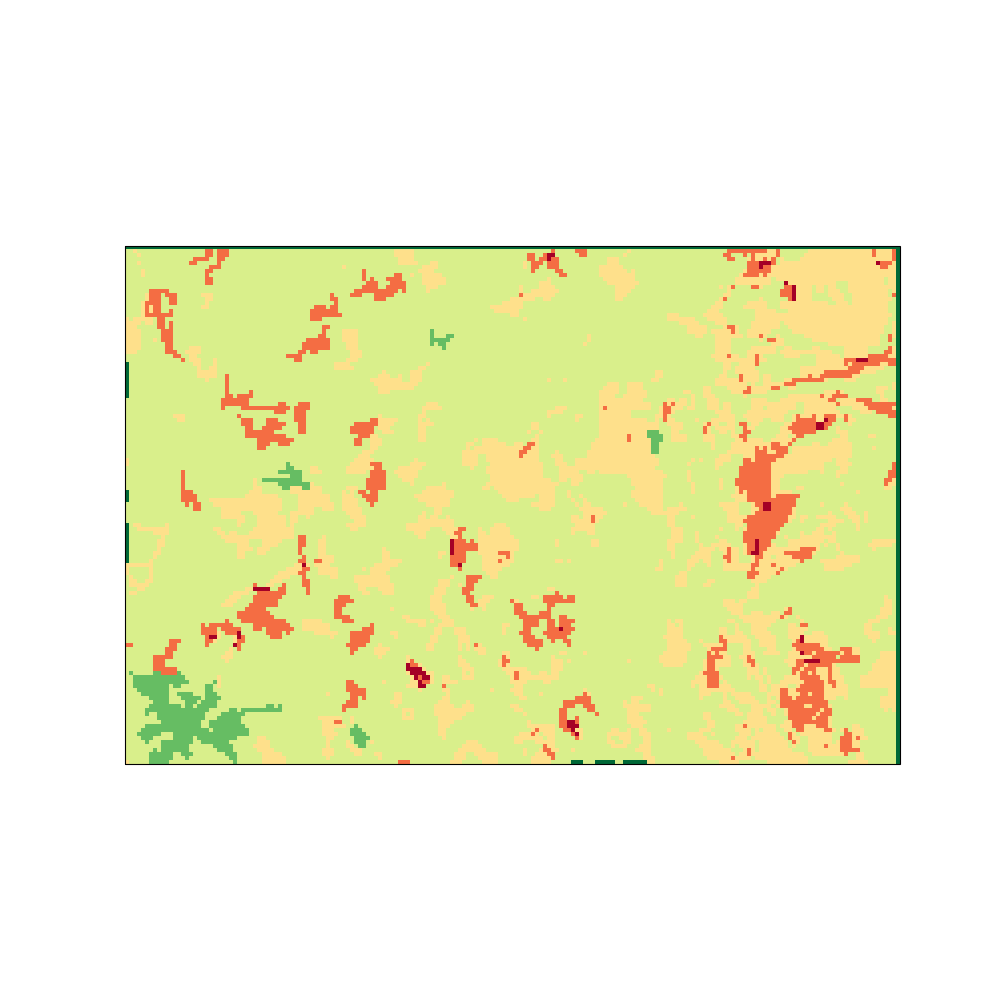

In [11]:
%matplotlib notebook

import numpy as np
import rasterio as rio
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pathlib import Path
import rasterio.warp
from rasterio.mask import mask
import pycrs
import os


# Additional work to be added: input for user specifying file names and/or explaining file import restrictions.

# Script assumes that raster imagery is prepared with identical resolution/identical cell size
paths = ('files/soil.tif', 'files/rainfall.tif', 'files/landcover.tif', 'files/slope.tif', 'files/research_area.shp',
		 'files/research_area.dbf','files/research_area.shx')
		# 'files/research_area.cpg', 'files/research_area.prj', 'files/research_area.sbn', 'files/research_area.shp.xml',
		# 'files/research_area.sbx' These are optional parts of the shapefiles, consider adding checks.
        # Checking file locations of tif files and all files typically belonging to a shapefile to confirm that they exist.

for path in paths:
	p = Path(path)
	if p.exists():
		print(path + ' loaded successfully.')
	else:
		print('One or more files in incorrect location or not named correctly, please review README for instructions.')
		quit()

research_area = gpd.read_file('files/research_area.shp') # assigning research shapefile to variable using geopandas

if research_area.crs != None:
	cooref = research_area.crs # variable cooref is assigned the CRS from the research_area shapefile if it has one
	print('CRS used for project: ' + str(research_area.crs)+'.')

else:
	print('No Coordinate Reference System found in Research Area Shapefile, please check README.')
	quit() # If the research_area shapefile does not have a CRS, then the script will print an error and exit

# Consider adding user input for CRS if research_area does not have one

# Code for clipping adapted from https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html
def getFeatures(gdf):
    # Function to transform research area shapefile into coordinates that rasterio can use.
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

clip_coords = getFeatures(research_area) # Boundary of research_area assigned as coordinates to clip_coords

def image_clip(input, output):
	# The function will ensure that input data has identical CRS as research_area.shp, otherwise an error will occur.
	# Afterwards the input data will be clipped to the extent of the research area and a new file will be saved to
	# the output, with meta data being copied and adjusted from the original input. Should the file defined via output
	# exist, then it will be deleted and replaced by the newly generated one. Input should be a filepath leading to
	# a suitable existing tif file, output defines the name and location of the output file.
	with rio.open(input) as dataset:
		if dataset.crs == cooref:  # Script only continues when crs for research_area and soil.tif are identical
			out_img, out_transform = mask(dataset=dataset, shapes=clip_coords,
										  crop=True)  # Cropping image to research_area
			out_meta = dataset.meta.copy()  # Copying original image meta data
			epsg_code = int(dataset.crs.data['init'][5:])  # Reading CRS data from original image
			global epsg_later # setting epsg_later as global variable for use outside of function
			epsg_later = epsg_code  # Saving EPSG code of project for later use, which is identical for all inputs so
									# overwriting it when function is called again does not change values.
			out_meta.update({"driver": "GTiff",
							 "height": out_img.shape[1],
							 "width": out_img.shape[2],
							 "transform": out_transform,
							 "crs": pycrs.parse.from_epsg_code(
								 epsg_code).to_proj4()})  # updating meta data for new cropped image
			global ra_meta # setting ra_meta as global variable for use outside of function
			ra_meta = out_meta  # ra_meta as variable to be used later outside this statement, out_meta should be identical
								# for all inputs, therefore having it overwritten when the function is called again is okay.
			if os.path.exists(output):
				os.remove(output)  # deletes clipped file if it exists so that script can be run repeatedly
				with rasterio.open(output, "w", **out_meta) as clip:
					clip.write(out_img)  # output of clipped image with updated meta data
					print('Old {} has been replaced.'.format(output))
			else:
				with rasterio.open(output, "w", **out_meta) as clip:
					clip.write(out_img)  # output of clipped image with updated meta data
					print('Old {} has been replaced.'.format(output))

		else:
			print('Coordinate Reference System for {} not identical to Research Area CRS.',input)
			quit()

image_clip('files/soil.tif','files/soil_clip.tif') # Calling function to check soil CRS and clip tif.
with rasterio.open('files/soil_clip.tif') as clipped:  	# Necessary as the previously opened clipped tifs from function
	soil = clipped.read()  								# were opened in write mode, preventing rasterio from reading.
	 													# Assigning clipped tif to variable as numpy array.

# Repeating above steps for remaining files.
image_clip('files/rainfall.tif','files/rainfall_clip.tif')
with rasterio.open('files/rainfall_clip.tif') as clipped:
	rainfall = clipped.read()

image_clip('files/landcover.tif','files/landcover_clip.tif')
with rasterio.open('files/landcover_clip.tif') as clipped:
	landcover = clipped.read()

image_clip('files/slope.tif','files/slope_clip.tif')
with rasterio.open('files/slope_clip.tif') as clipped:
	slope = clipped.read()

# The following code works, but had to be deprecated due to HOW it works: the CRS of the research_area is applied
# to an existing tif file, creating a transformed new tif, however due to the transformation the cell/pixel
# size may be changed slightly. This would, without work that was not able to be completed, prevent a raster
# calculation to work correctly, as the pixels no longer overlay correctly. Instead, the script will stop with
# an error message if the CRS of one of the files does not match the research_area CRS. Leaving for potential future use.
'''
dst_crs = cooref  # destination CRS is based on the previously assigned CRS of the research_area,
			   # following script adapted from https://rasterio.readthedocs.io/en/latest/topics/reproject.html

with rio.open('files/soil.tif') as src:
	transform, width, height = rio.warp.calculate_default_transform(
		src.crs, dst_crs, src.width, src.height, *src.bounds)
	kwargs = src.meta.copy()  # this copies the meta dict object
	kwargs.update({
		'crs': dst_crs,
		'transform': transform,
		'width': width,
		'height': height
	})

	with rio.open('files/soil_updated.tif', 'w', **kwargs) as dst:
		for i in range(1, src.count + 1):
			rio.warp.reproject(
				source=rio.band(src, i),
				destination=rio.band(dst, i),
				src_transform=src.transform,
				src_crs=src.crs,
				dst_transform=transform,
				dst_crs=dst_crs,
				resampling=rio.warp.Resampling.nearest)
'''

# Visual check that each variable is assigned a numpy array, not required for further processing and meant as a way to
# ensure integrity of data.
print('Data types: soil: '+ str(type(soil)) + ' , rainfall: ' + str(type(rainfall)) + ' , landcover: '
	  + str(type(landcover)) + ', slope: ' + str(type(slope)))

# Calculations combining risk factors soil, slope and rainfall as follows, an error will appear if one or more of the
# tifs cover a smaller extent than the research area. Consider adding check by comparing width and height of clipped tifs.
# The * 1 ensures that the output is saved as integer, otherwise it would be saved as Boolean.
very_high = ((soil == 1) & (slope > 7) & (rainfall >= 800)) * 1
high = ((soil == 1) & (slope >= 3) & (slope <= 7) & (rainfall >= 800)) * 1 | \
	   ((soil == 2) & (slope > 7) & (rainfall >= 800)) * 1 | \
	   ((soil == 1) & (slope > 7) & (rainfall < 800)) * 1
moderate = ((soil == 1) & (slope >= 3) & (slope <= 7) & (rainfall < 800)) * 1 | \
		   ((soil == 1) & (slope >= 2) & (slope <= 3) & (rainfall >= 800)) * 1 | \
		   ((soil == 2) & (slope > 7) & (rainfall < 800)) * 1 | \
		   ((soil == 2) & (slope >= 3) & (slope <= 7) & (rainfall >= 800)) * 1
lower = ((soil == 1) & (slope >= 2) & (slope <= 3) & (rainfall < 800)) * 1 | \
		((soil == 2) & (slope >= 2) & (slope <= 3) & (rainfall >= 800)) * 1 | \
		((soil == 3) & (slope > 7) & (rainfall >= 800)) * 1
slight = ((soil == 1) & (slope < 2) & (rainfall >= 800)) * 1 | \
		 ((soil == 2) & (slope < 2) & (rainfall >= 800)) * 1 | \
		 ((soil == 3) & (slope >= 3) & (slope <= 7) & (rainfall >= 800)) * 1 | \
		 ((soil == 3) & (slope >= 2) & (slope <= 3) & (rainfall >= 800)) * 1 | \
		 ((soil == 3) & (slope < 2) & (rainfall >= 800)) * 1

# Reclassification to allow combination of very high to slight risk. Changing  1 to 1 (value for slight is not changed),
# 2 (lower), 3 (moderate), 4 (high) and 5 (very high).
very_high[np.where(very_high == 1)] = 5
high[np.where(high == 1)] = 4
moderate[np.where(moderate == 1)] = 3
lower[np.where(lower == 1)] = 2

# Combining all risk levels in one numpy array assigned to variable risk1.
risk1 = very_high + high + moderate + lower + slight

'''
# The following is code to save each risk category and the combination thereof as tif files for potential trouble-
# shooting use and/or verification of the results so far. Uncomment for use but note that if files already exist there
# might appear errors as no conditions to delete/ignore existing files were added. Manual deletion beforehand advised.
# Also, these files will have no metadata, but CRS is identical to original research_area.shp.

with rasterio.open('files/risk1.tif', "w", **ra_meta) as risk1_dataset:
	risk1_dataset.write(risk1)  # output of combination of slope/soil/rainfall risk

with rasterio.open('files/very_high.tif', "w", **ra_meta) as very_high_risk:
	very_high_risk.write(very_high)  # output of clipped image with updated meta data

with rasterio.open('files/high.tif', "w", **ra_meta) as high_risk:
	high_risk.write(high)  # output of clipped image with updated meta data

with rasterio.open('files/moderate.tif', "w", **ra_meta) as moderate_risk:
	moderate_risk.write(moderate)  # output of clipped image with updated meta data

with rasterio.open('files/lower.tif', "w", **ra_meta) as lower_risk:
	lower_risk.write(lower)  # output of clipped image with updated meta data

with rasterio.open('files/slight.tif', "w", **ra_meta) as slight_risk:
	slight_risk.write(slight)  # output of clipped image with updated meta data
'''

# Calculation to combine previously created risk dataset consisting of soil, rainfall and slope, with landcover.
very_high_final = ((landcover == 4) & (risk1 == 5)) * 1
high_final = ((landcover == 3) & (risk1 == 5)) * 1 | \
			 ((landcover == 4) & (risk1 >= 3) & (risk1 <= 4)) * 1
moderate_final = ((landcover == 1) & (risk1 == 5)) * 1 | \
				 ((landcover == 2) & (risk1 >= 4) & (risk1 <= 5)) * 1 | \
				 ((landcover == 3) & (risk1 >= 3) & (risk1 <= 4)) * 1 | \
				 ((landcover == 4) & (risk1 <= 2)) * 1
lower_final = ((landcover == 1) & (risk1 >= 3) & (risk1 <= 4)) * 1 | \
			  ((landcover == 2) & (risk1 >= 2) & (risk1 <= 3)) * 1 | \
			  ((landcover == 3) & (risk1 <= 2)) * 1
slight_final = ((landcover == 1) & (risk1 <= 2)) * 1 | \
			   ((landcover == 2) & (risk1 == 1)) * 1
none_final = (landcover == 0) * 1

# Reclassifying to allow addition of all risk scores in one tif. Note difference in risk values (1 to 6 compared
# to 1 to 5) due to addition of sixth risk category.
very_high_final[np.where(very_high_final == 1)] = 6
high_final[np.where(high_final == 1)] = 5
moderate_final[np.where(moderate_final == 1)] = 4
lower_final[np.where(lower_final == 1)] = 3
slight_final[np.where(slight_final == 1)] = 2
none_final[np.where(none_final == 1)] = 1

# Calculation of final risk score.
risk_final = very_high_final + high_final + moderate_final + lower_final + slight_final + none_final

# Saving of final map. If the file existed beforehand, then it will be deleted and replaced by the new one.
if os.path.exists('files/Soil_Erosion_Risk.tif'):
	os.remove('files/Soil_Erosion_Risk.tif')
	with rasterio.open('files/Soil_Erosion_Risk.tif', "w", **ra_meta) as risk_final_dataset:
		risk_final_dataset.write(risk_final)  # Output of combination of slope/soil/rainfall risk plus landcover risk.
	print('Old Soil_Erosion_Risk.tif has been replaced.')
else:
	with rasterio.open('files/Soil_Erosion_Risk.tif', "w", **ra_meta) as risk_final_dataset:
		risk_final_dataset.write(risk_final)  # Output of combination of slope/soil/rainfall risk plus landcover risk.
	print('Soil Erosion Risk tif has been created.')

# Displaying the generated image after running the script, applicable to the use of the script in a Jupyter Notebook
# and is intended only to give an overview, with a colour map going from dark green (no risk) to dark red (very high
# risk). Further work should be considered by adding a legend, scale bar and potentially a north arrow.

with rio.open('files/Soil_Erosion_Risk.tif') as dataset:
    img = dataset.read()
    xmin, ymin, xmax, ymax = dataset.bounds

myCRS = str(cooref) # Converting CRS from research area into string, as CRS itself cannot be sliced using [5:].
myCRS = ccrs.epsg(myCRS[5:]) # Overwriting myCRS with usable data by obtaining projection from EPSG code.
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=myCRS))

# np.squeeze is required as array would otherwise be considered three-dimensional, colour map reversed using _r
# to visualize risk in a meaningful way.
ax.imshow(np.squeeze(img), cmap='RdYlGn_r', transform=myCRS, extent=[xmin, xmax, ymin, ymax])
